In [ ]:
# -*- coding: utf-8 -*-
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#    http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or
# implied.
# See the License for the specific language governing permissions and
# limitations under the License.
#

# Content-based Movie Recommender

**Source:** Inspired by [OfferZen RecSys](https://www.offerzen.com/blog/how-to-build-a-content-based-recommender-system-for-your-product).

**Data:** MovieLens data --> download the file [ml_latest.zip](https://grouplens.org/datasets/movielens/) and then unzip it into the folder `data_latest/`.

We are diving into the **fascinating world of movie recommendations!** Our focus will be on developing a Content-Based Recommender System that suggests movies to users based on their individual preferences.

Delivering the most pertinent information to users is a crucial function for any product. For effective execution of this task, it's essential to accurately derive user preferences from your raw data. Below is a structured approach to help you begin this process.

## What is Content-based filtering
**Content-based filtering**: This method uses attributes of the content to recommend similar content. **It doesn’t have a cold-start problem** because it works through attributes or tags of the content, such as actors, genres or directors, so that new movies can be recommended right away.

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

## Load the MovieLens data

Our dataset comprises a comprehensive list of movies, complete with details such as titles, genres, moods, evenets, directors, and possibly user ratings. We'll use this data to understand user preferences and recommend similar content. 

**Download the file [ml_latest.zip](https://grouplens.org/datasets/movielens/) and then unzip it into the folder `data_latest/`.**

In [ ]:
df_movies = pd.read_csv('data_latest/movies.csv')
df_links = pd.read_csv('data_latest/links.csv')
df_ratings = pd.read_csv('data_latest/ratings.csv')
df_genome_tags = pd.read_csv('data_latest/genome-tags.csv')
df_genome_scores = pd.read_csv('data_latest/genome-scores.csv')

In [ ]:
print('Movies dataframa shape: ' + str(df_movies.shape))
df_movies.head()

In [ ]:
print('Ratings dataframa shape: ' + str(df_ratings.shape))
df_ratings.head()

In [ ]:
print('Genomes dataframe shape: ' + str(df_genome_tags.shape))
df_genome_tags.head()

In [ ]:
print('Genome scores dataframe shape: ' + str(df_genome_scores.shape))
df_genome_scores.head()

## Data Preprocessing
`threshold`: We set a threshold of 0.3 for relevance. This means we only consider tags that have a relevance score higher than 0.3, ensuring that we keep the most significant tags for each movie.

Our dataset contains a genome_scores table that associates tags with movies based on their relevance. To ensure the quality of our recommendations, we implement the following preprocessing step:

In [ ]:
# Only keep tags with relevance higher than 0.3
threshold = 0.3
df_movie_tags = df_genome_scores[df_genome_scores.relevance > threshold][['movieId', 'tagId']]
df_movie_tags.head()

### Which is movie with Id 1?

In [ ]:
df_movies[df_movies.movieId == 1]

### Let's have a look at a few of the tags Toy Story 
This code is used to display a random sample of descriptive tags associated with a specific movie, which in this case is presumed to be "Toy Story".

In [ ]:
df_movie_tags[df_movie_tags['movieId'] == 1].merge(df_genome_tags, on='tagId').sample(10)

### Encode features
After executing the above code, `df_tags_to_movies` will hold a DataFrame where each movie is linked with its corresponding tag IDs.

In [ ]:
df_tags_to_movies = pd.merge(df_movie_tags, df_genome_tags, on='tagId', how='left')[['movieId', 'tagId']]
df_tags_to_movies['tagId'] = df_tags_to_movies.tagId.astype(str)
print('Shape of "df_tags_to_movies": ' + str(df_tags_to_movies.shape))
df_tags_to_movies.head()

We define a function `_concatenate_tags_of_movie` that takes a collection of tags and merges them into a single space-separated string. This helps in eliminating duplicate tags and reducing dimensionality.

In [ ]:
def _concatenate_tags_of_movie(tags):
    tags_as_str = ' '.join(set(tags))
    return tags_as_str

We then group our movie-tag DataFrame by movie and apply our function to concatenate the tags for each movie.

In [ ]:
df_tags_per_movie = df_tags_to_movies.groupby('movieId')['tagId'].agg(_concatenate_tags_of_movie)
df_tags_per_movie.name = 'movie_tags'
df_tags_per_movie = df_tags_per_movie.reset_index()

This results in a DataFrame where each movie is represented by a string of its associated tags, ready to be used as input for our recommendation algorithms.

In [ ]:
df_tags_per_movie[df_tags_per_movie['movieId'] == 1]

We calculate the mean, median, and count (size) of ratings for each movie in our dataset:

In [ ]:
df_avg_ratings  = df_ratings.groupby('movieId')['rating'].agg(['mean', 'median', 'size'])
df_avg_ratings.columns = ['rating_mean', 'rating_median', 'num_ratingsdf_tags_per_movie']
df_avg_ratings = df_avg_ratings.reset_index()
df_avg_ratings.head()

Next, we merge the movie details with the calculated rating statistics:

In [ ]:
df_movies_with_ratings = pd.merge(df_movies, df_avg_ratings, how='left', on='movieId')
df_movies_with_ratings.head()

Combines the `df_movies_with_ratings` DataFrame (which already includes the movie details along with their average and median ratings and count of ratings) with the `df_tags_per_movie` DataFrame (which contains the aggregated tags for each movie).

In [ ]:
df_data = pd.merge(df_movies_with_ratings, df_tags_per_movie, how='left', on='movieId')

Filters the DataFrame to include only those rows where the movie_tags data is not missing, ensuring that we work with complete data.

In [ ]:
df_data_with_tags = df_data[~df_data.movie_tags.isnull()].reset_index(drop=True)
df_data_with_tags.head()

## TF-IDF vectors
TF-IDF can be broken down into two parts TF (term frequency) and IDF (inverse document frequency). TF-IDF is a statistical measure used to evaluate the importance of a word to a document relative to a collection of documents (corpus). This technique considers not only the frequency of a word in a single document (term frequency) but also how common the word is across all documents (document frequency). By doing this, it diminishes the impact of commonly used words that are less informative in the context of the specific document.

**What is TF (term frequency)?**

Term frequency works by looking at the frequency of a particular term you are concerned with relative to the document. There are multiple measures, or ways, of defining frequency:

- Number of times the word appears in a document (raw count).
- Term frequency adjusted for the length of the document (raw count of occurences divided by number of words in the document).
- Logarithmically scaled frequency (e.g. log(1 + raw count)).
- Boolean frequency (e.g. 1 if the term occurs, or 0 if the term does not occur, in the document).


**What is IDF (inverse document frequency)?**

Inverse document frequency looks at how common (or uncommon) a word is amongst the corpus. IDF is calculated as follows where **t** is the term (word) we are looking to measure the commonness of and **N** is the number of documents (d) in the corpus (D).. The denominator is simply the number of documents in which the term, **t**, appears in. 
<div>
<center>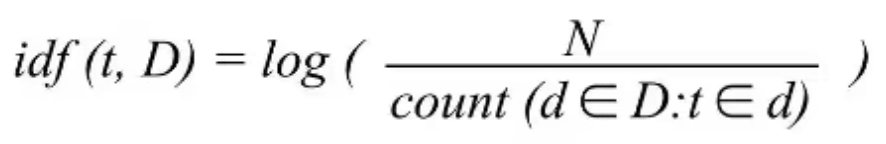</center>
</div>

`Note:` It can be possible for a term to not appear in the corpus at all, which can result in a divide-by-zero error. One way to handle this is to take the existing count and add 1. Thus making the denominator (1 + count). An example of how the  popular library scikit-learn handles this can be seen below.

<br/>
<div>
<center>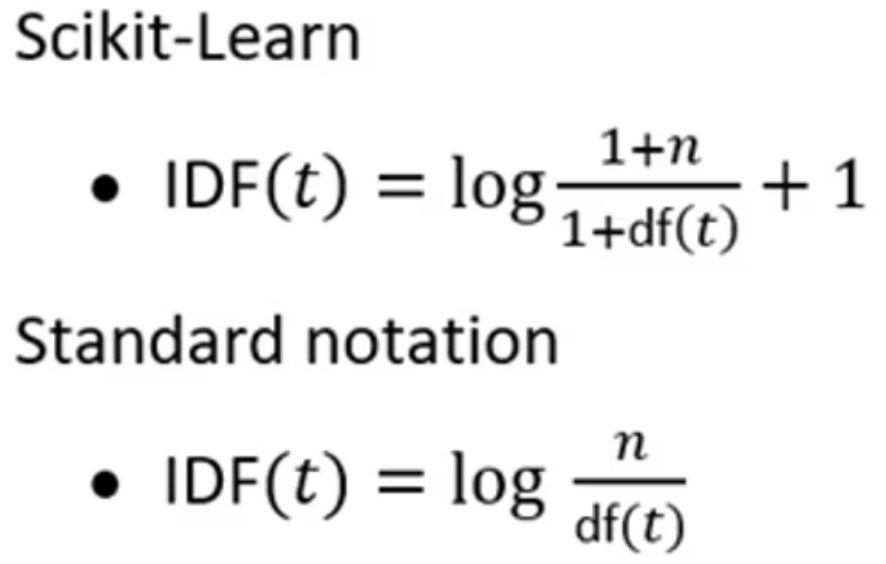</center>
</div>

**Putting it together: TF-IDF**

To summarize the key intuition motivating TF-IDF is the importance of a term is inversely related to its frequency across documents.TF gives us information on how often a term appears in a document and IDF gives us information about the relative rarity of a term in the collection of documents. By multiplying these values together we can get our final TF-IDF value.

<br/>
<div>
<center>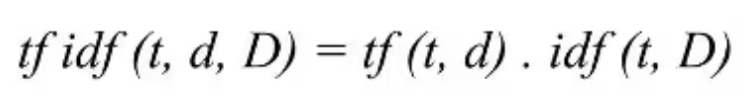</center>
</div>
<br/>

The higher the TF-IDF score the more important or relevant the term is; as a term gets less relevant, its TF-IDF score will approach 0.

### Code explanation:
We utilize the TfidfVectorizer to convert the collection of raw movie tags into a matrix of TF-IDF features. Initializes the vectorizer that will be used for converting text to feature vectors.

In [ ]:
tf_idf = TfidfVectorizer()

This method learns the term frequencies and inverse document frequencies from the `movie_tags`, then transforms the `movie_tags` into a TF-IDF-weighted document-term matrix.

In [ ]:
len(df_data_with_tags.movie_tags[0])

In [ ]:
df_movies_tf_idf_described = tf_idf.fit_transform(df_data_with_tags.movie_tags)
df_movies_tf_idf_described

In [ ]:
df_data_with_tags.movie_tags

Once we have our movie tags vectorized, we compute the cosine similarity between all `movies`, which will serve as the basis for our recommendation system.

In [ ]:
df_tfidf_m2m = pd.DataFrame(cosine_similarity(df_movies_tf_idf_described))

In [ ]:
print(df_tfidf_m2m.shape)
df_tfidf_m2m.head()

To make our similarity matrix more intuitive, we replace numerical indices with the actual movie IDs from our dataset.

In [ ]:
index_to_movie_id = df_data_with_tags['movieId']
df_tfidf_m2m.columns = [str(index_to_movie_id[int(col)]) for col in df_tfidf_m2m.columns]
df_tfidf_m2m.index = [index_to_movie_id[idx] for idx in df_tfidf_m2m.index]
df_tfidf_m2m.head()

### Most similar movies to Toy Story
Now, we utilize our previously computed cosine similarity matrix to find movies most similar to a particular title and to calculate the similarity between two specific movies.
To identify movies similar to "Toy Story," we sort the cosine similarity scores for "Toy Story" in descending order and display the top results:

In [ ]:
df_tfidf_m2m.iloc[0].sort_values(ascending=False)[:10]

We can look up the details of these movies by their IDs to explore more about these similar movies, we can see that the most similar movie is `Toy Story 2`.

In [ ]:
df_data_with_tags[df_data_with_tags.movieId == 3114]

The third movie is also very similar to `Toy Story`:

In [ ]:
df_data_with_tags[df_data_with_tags.movieId == 4886]

In [ ]:
df_data_with_tags[df_data_with_tags.title.str.contains('Terminator 2')]

In [ ]:
df_tfidf_m2m.iloc[1][560]

### Build user profile for user #1
In this segment, we construct a profile for User with ID 1 by merging their movie rating history with our comprehensive movie dataset. This profile helps us understand the user's preferences in movies, which is essential for making personalized recommendations.

In [ ]:
df_data_with_tags.head(1)

In [ ]:
df_ratings.head(1)

In [ ]:
df_user_ratings = df_ratings[df_ratings.userId == 1]

In [ ]:
df_user_data_with_tags = df_data_with_tags.reset_index().merge(df_user_ratings, on='movieId')

In [ ]:
df_user_data_with_tags[['title', 'rating']]

In this step, we assign weights to the user's rated movies and use these weights to generate a user profile vector based on the movies' TF-IDF representations. The ratings are divided by 5, assuming the maximum rating is 5, to normalize them into a weight between 0 and 1.

In [ ]:
df_user_data_with_tags['weight'] = df_user_data_with_tags['rating']/5.

Next, we compute the user profile by taking the dot product of the TF-IDF matrix of the movies with the user's weight vector. This produces a weighted sum of the TF-IDF vectors for the movies the user has rated, which represents the user's preferences in the feature space defined by the TF-IDF model.

In [ ]:
user_profile = np.dot(df_movies_tf_idf_described[df_user_data_with_tags['index'].values].toarray().T, 
                      df_user_data_with_tags['weight'].values)

In [ ]:
df_movies_tf_idf_described[df_user_data_with_tags['index'].values].toarray().T.shape

In [ ]:
df_movies_tf_idf_described[df_user_data_with_tags['index'].values].toarray().T.shape

In [ ]:
df_user_data_with_tags['weight'].values.shape

We calculate the cosine similarity between the user's profile and each movie's TF-IDF vector. `np.atleast_2d(user_profile)`: This ensures that the user profile is treated as a two-dimensional array, which is necessary for the cosine_similarity function.

In [ ]:
C = cosine_similarity(np.atleast_2d(user_profile), df_movies_tf_idf_described)

To identify the top movie recommendations, we sort the similarity scores in descending order:

In [ ]:
R = np.argsort(C)[:, ::-1]

We want to recommend movies that the user hasn't already rated. To achieve this, we filter out movies that appear in the user's rated movies list:

In [ ]:
recommendations = [i for i in R[0] if i not in df_user_data_with_tags['index'].values]

Finally, we display the titles of the top recommended movies:

In [ ]:
df_data_with_tags['title'][recommendations].head(30)

### Evaluation of Recommender System
- For content-based filtering, we should choose from __similarity metrics__.
- In this case, we have an item's meta-data available, so we can easily recommend new items to the user. For example, if we watched a movie A, we can recommend another movie based on extensive meta-data tags for other movies and calculate the distance between them and movie A.
- In this case we used __cosine similarity__. Other common metrics are __Jaccard similarity__, __Euclidean distance__, and __Pearson Coefficient__.